# A07 - [Project: Bicycle Sharing](https://dtkaplan.github.io/DataComputingEbook/project-bicycle-sharing.html#project-bicycle-sharing)
Kaplan, Daniel & Matthew Beckman. (2021). _Data Computing_. 2nd Ed. [Home](https://dtkaplan.github.io/DataComputingEbook/).

---

```{admonition} Revised
19 Jun 2023
```
```{contents}
```

---

## Programming Environment

To use leaflet on macOS

```
brew install gdal proj
```

```r
remotes::install_github("rspatial/terra", configure.args = "--with-gdal-config=/opt/homebrew/bin/gdal-config --with-proj-include=/opt/homebrew/opt/proj/include --with-proj-lib=/opt/homebrew/opt/proj/lib --with-proj-share=/opt/homebrew/opt/proj/share/proj", type = "source", force = TRUE)

```

In [1]:
R.version.string
.libPaths()

library(dcData)
library(leaflet)
library(lubridate)
#library(Rcpp)
library(tidyverse)

[1] "R version 4.3.0 (2023-04-21)"

[1] "/Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/library"


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr   1.1.2     ✔ readr   2.1.4
✔ forcats 1.0.0     ✔ stringr 1.5.0
✔ ggplot2 3.4.2     ✔ tibble  3.2.1
✔ purrr   1.0.1     ✔ tidyr   1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



terra (NA -> 1.7-37) [CRAN]


Installing 1 packages: terra

Warning message in download.file(url, destfile, method, mode = "wb", ...):
“downloaded length 0 != reported length 0”
Warning message in download.file(url, destfile, method, mode = "wb", ...):
“URL 'https://cran.r-project.org/bin/macosx/big-sur-arm64/contrib/4.3/terra_1.7-37.tgz': Timeout of 60 seconds was reached”


Error in download.file(url, destfile, method, mode = "wb", ...) : 
  download from 'https://cran.r-project.org/bin/macosx/big-sur-arm64/contrib/4.3/terra_1.7-37.tgz' failed


Warning message in download.packages(pkgs, destdir = tmpd, available = available, :
“download of package ‘terra’ failed”


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/private/var/folders/89/5r24znsj4jbfr7zrccy5yn0c0000gn/T/RtmprdUpU5/remotes1077f744b39b7/rstudio-leaflet-0f8e831/DESCRIPTION’ ... OK
* preparing ‘leaflet’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Removed empty directory ‘leaflet/docs’
Removed empty directory ‘leaflet/man-roxygen’
* building ‘leaflet_2.1.2.9000.tar.gz’



---

In [28]:
# information about the location of each of the stations in the system
station_url <- 'https://mdbeckman.github.io/dcSupplement/data/DC-Stations.csv'
Stations    <- readr::read_csv(station_url)
# the rental history from 2014 Q4
#   the `Trips` data table is a random subset of 10,000 trips from the full quarterly data
#   the full data set of more than 600,000 trips can be accessed by removing `-Small` from the url
trip_url    <- 'https://mdbeckman.github.io/dcSupplement/data/Trips-History-Data-2014-Q4-Small.rds'
Trips       <- readRDS(gzcon(url(trip_url)))

source('https://mdbeckman.github.io/dcSupplement/R/haversine.R')

Rows: 347 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): name
dbl (4): lat, long, nbBikes, nbEmptyDocks

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [29]:
# Stations <-
#   Stations %>%
#     select(lat, long)
# Stations %>%
#   head()

In [30]:
# Trips <-
#   Trips %>%
#     select(sstation, estation, client, sdate, edate)
# Trips %>%
#   head()

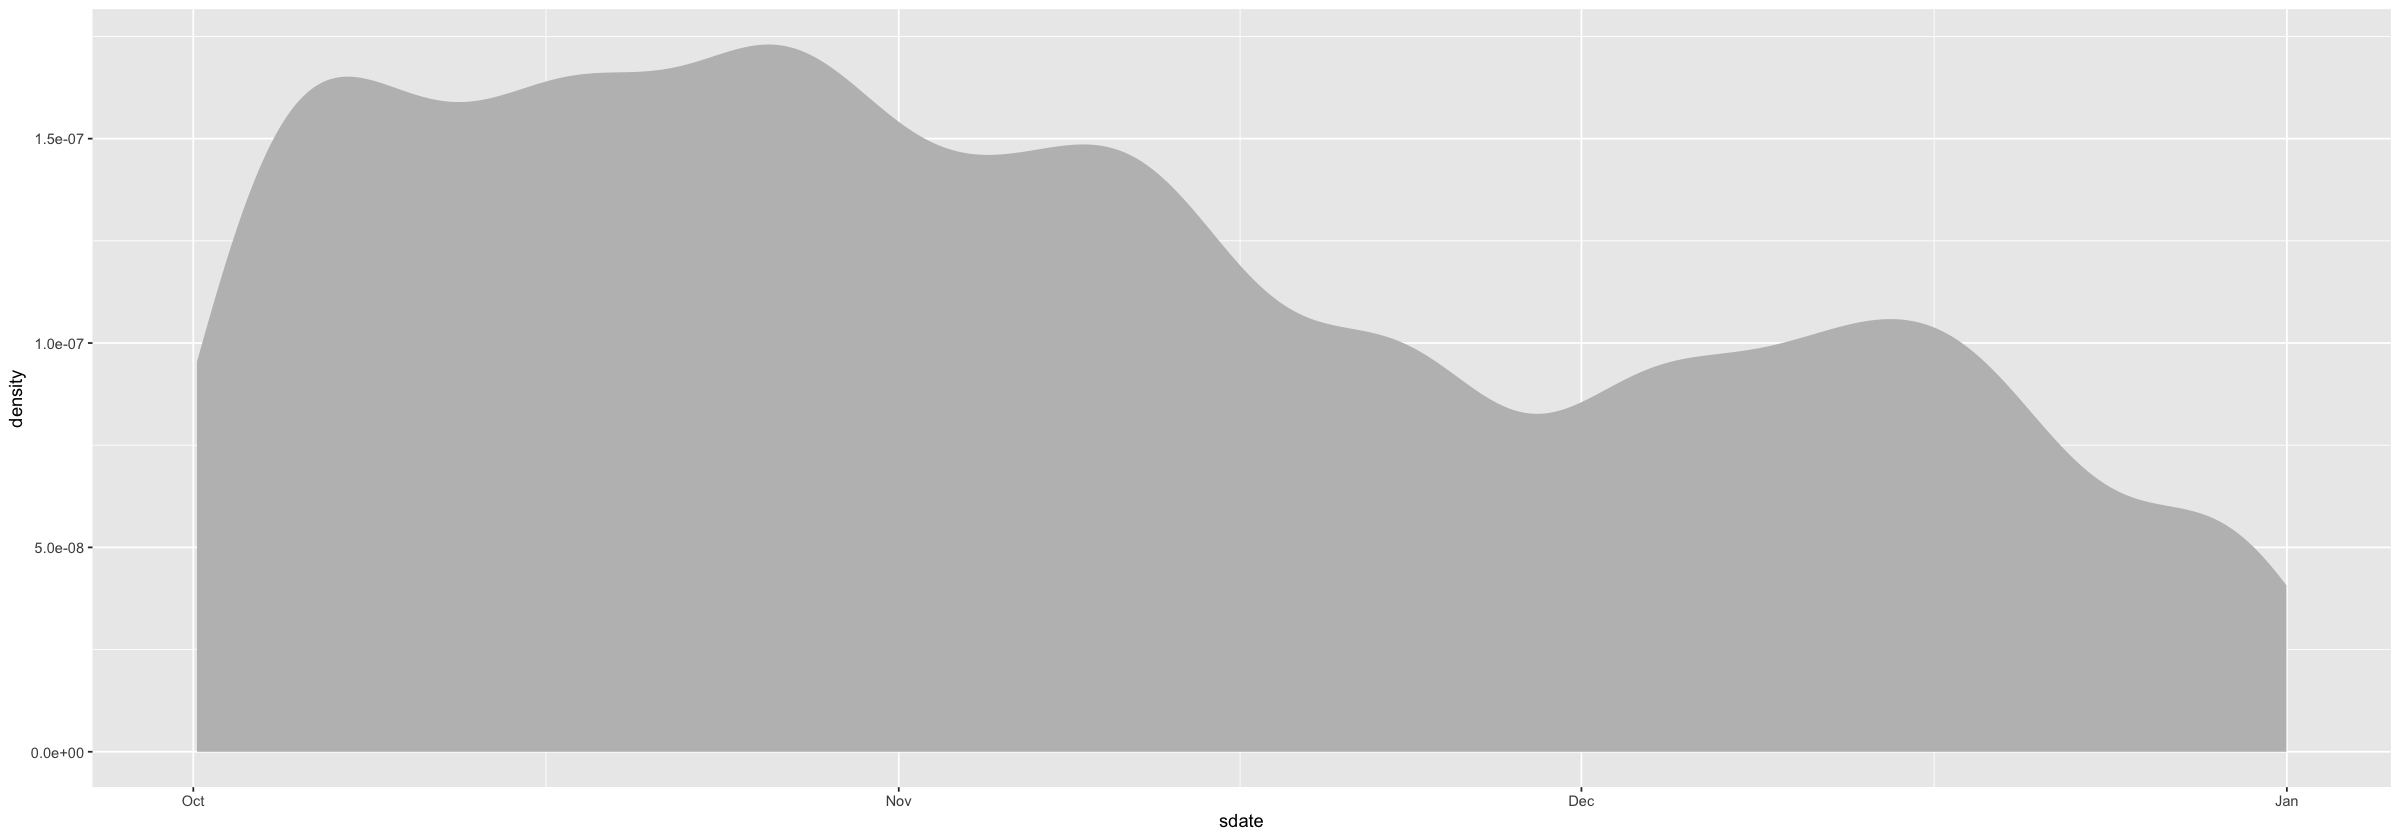

In [31]:
# the distribution of times that bikes were checked out
Trips %>%
  ggplot(aes(x = sdate)) +
    geom_density(fill = 'gray', color = NA)

## How long?

Make a box-and-whisker plot showing the distribution of the duration of rental events broken down by `client`. The duration of the rental can be calculated as `as.numeric(edate - sdate)`. The units will be in either hours, minutes, or seconds. It should not be much trouble for you to figure out which one. When you make your plot, you will likely find that the axis range is being set by a few outliers. These may be bikes that were forgotten. Arrange your scale to ignore these outliers, or filter them out.

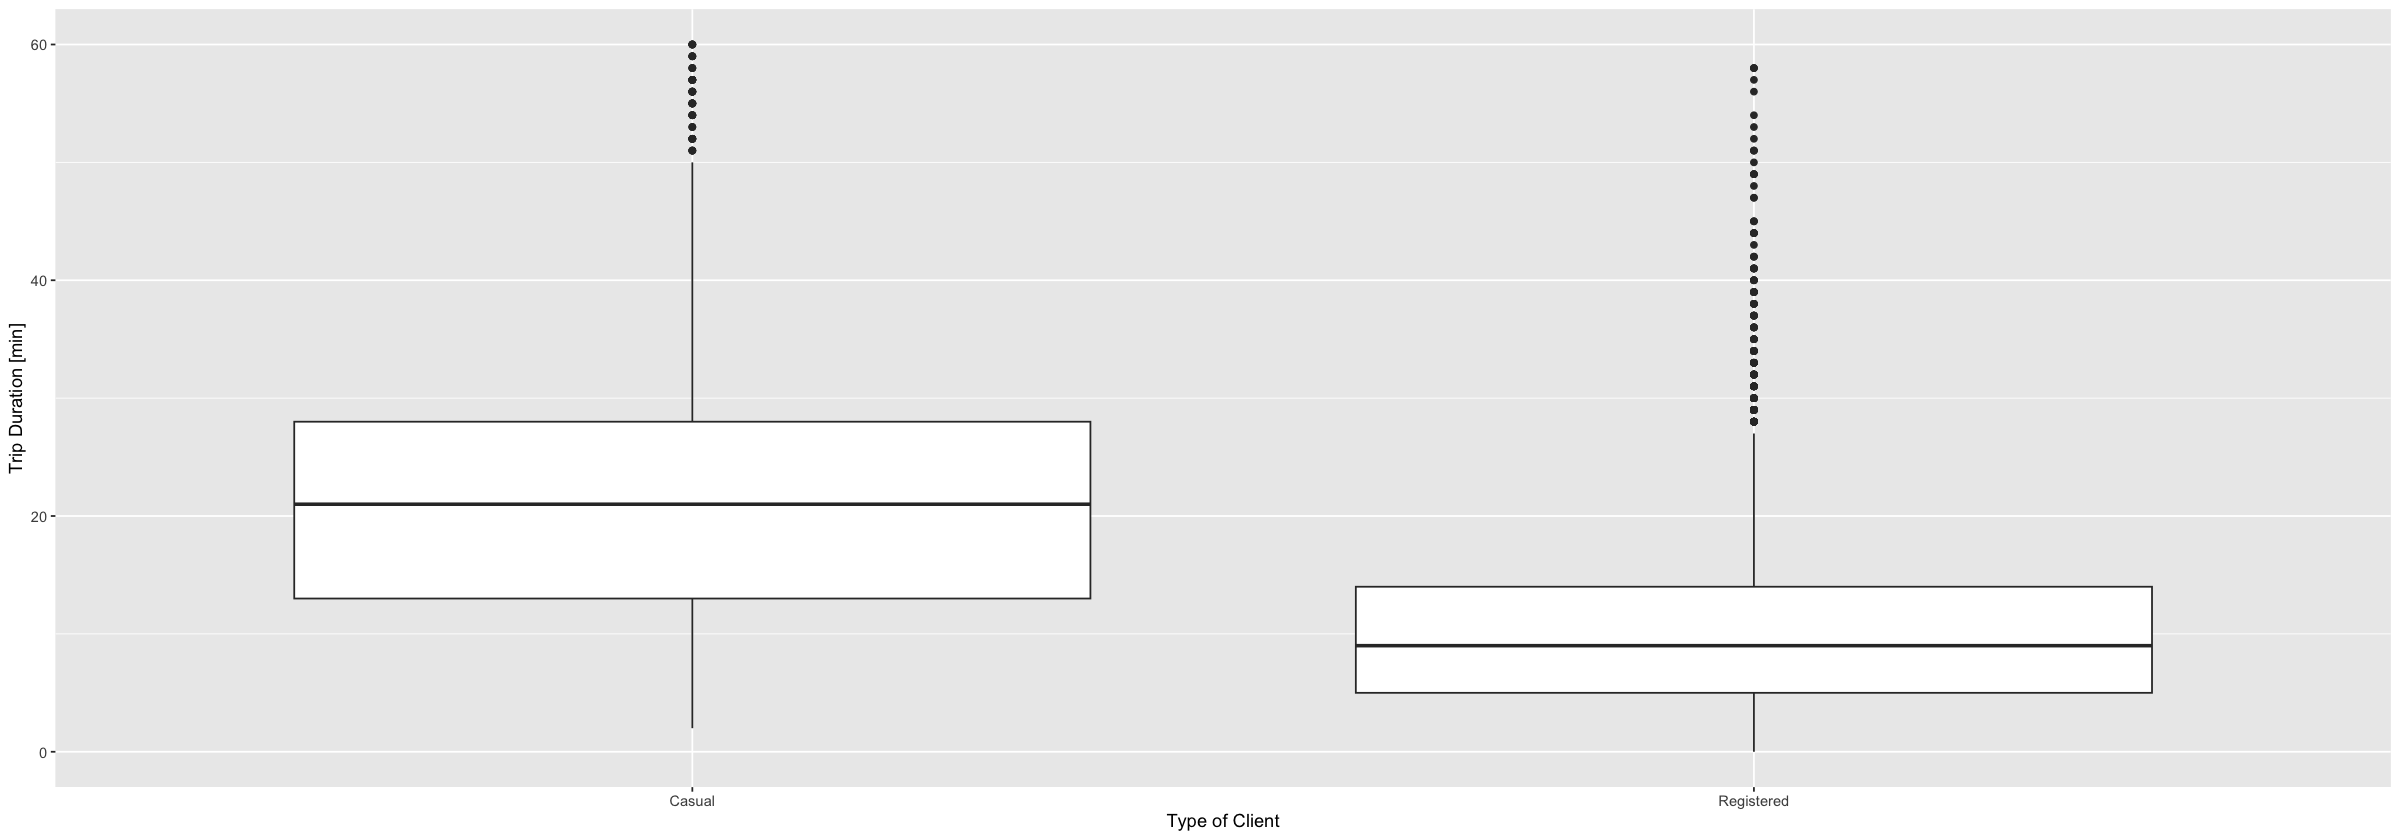

In [32]:
Trips %>%
  mutate(duration = as.numeric(edate - sdate)) %>%
  filter(duration <= 3600) %>%
  ggplot() +
    geom_boxplot(
      mapping = aes(x = client, y = duration / 60)
    ) +
    labs(x = 'Type of Client', y = 'Trip Duration [min]')

## When are bikes used?

[1] Variable `Trips$sdate` indicates the datetime that the bicycle was checked out of the station. Make histograms or density plots of each of these discrete components. Explain what each plot is showing about how bikes are checked out. For example, the distribution by hour of the day shows that few bikes are checked out before 5am, and that there are busy times around rush hour: 8am and 5pm.

* Day of the year: bike rentals are highest in October; decline in November; and pick up again in the first half of December.
* Day of the week: bike rentals are fairly stable over the course of the week; Thursday and Friday see the most rentals, and Saturday and Sunday see the least. Monday sees a little bit more than Tuesday and Wednesday.
* Hour of the day: bike rentals are low before 5:00am; spike up during morning rush hour; decrease a bit throughout the day; spike back up during evening rush hour; and rapidly decline to early morning levels into the night.
* Minute of the hour: I'm not sure there's much of a trend along this scale, other than that the numbers of rentals oscillate a bit (i.e., it is not fixed).

 [2] A similar sort of display of events per hour can be accomplished by calculating and displaying each hour's count. The graphic shows a lot of variation of bike use over the course of the day. Now consider two additional variables: the day of the week and the client type. Group the bike rentals by three variables: hour of the day, day of the week, and client type. Find the total number of events in each grouping and plot this count versus hour. Use the `group` aesthetic to represent one of the other variables and faceting to represent the other. (Hint: utilize `facet_wrap()` in the plotting commands.) Make the same sort of display of how bike rental vary of hour, day of the week, and client type, but use `geom_density()` rather than grouping and counting. Compare the two displays--one of discrete counts and one of density--and describe any major differences.

Generally, registered clients rent more bikes than casual clients across hour of the day and across day of the week. On an hourly basis, however, casual client rentals usually reach a maximum in the afternoon, when registered client rentals dip in between morning and evening rush hour. Also, casual client rentals peak over the weekend, when registered client rentals drop the most.

In [33]:
Trips$sdate[1]
lubridate::yday(Trips$sdate)[1] # day of the year from 1 to 365
lubridate::wday(Trips$sdate)[1] # day of the week from Sunday to Saturday
lubridate::hour(Trips$sdate)[1] # hour of the day
lubridate::minute(Trips$sdate)[1] # minute of the hour

[1] "2014-10-15 08:58:00 UTC"

[1] 288

[1] 4

[1] 8

[1] 58

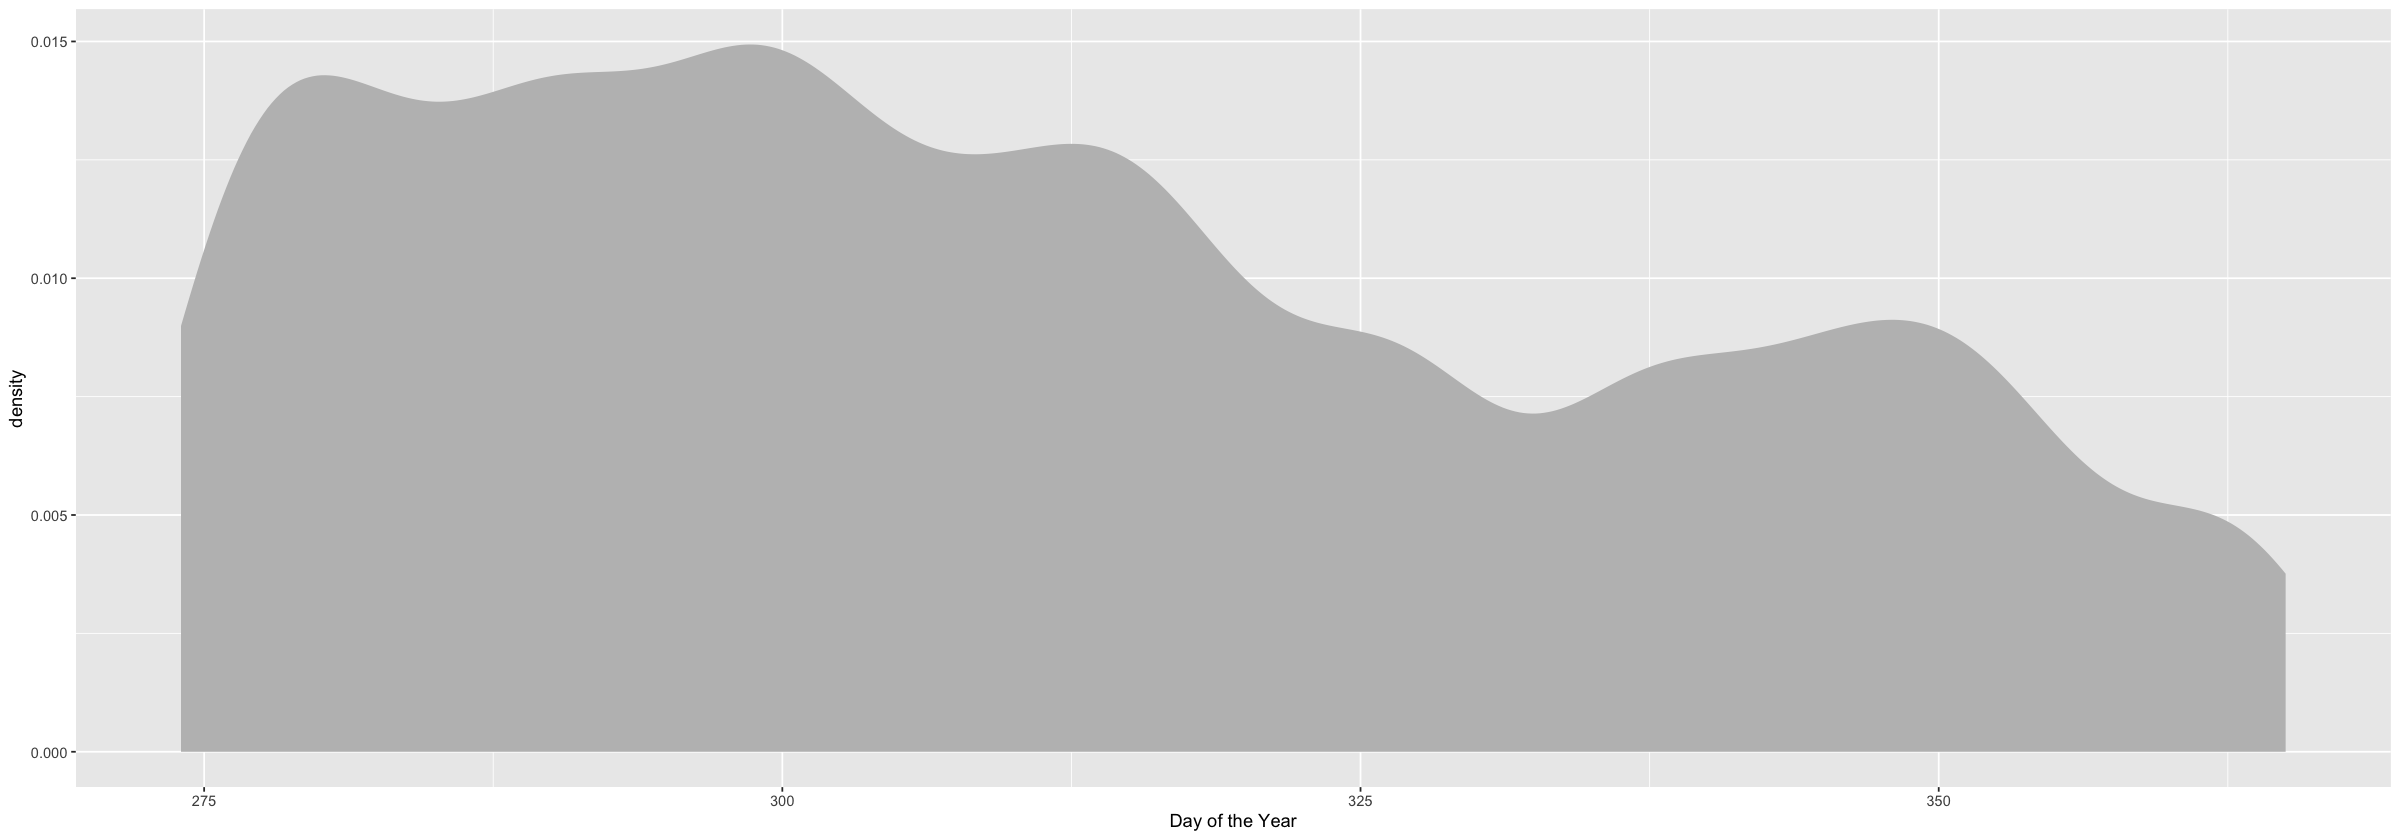

In [34]:
Trips %>%
  ggplot(aes(x = lubridate::yday(sdate))) +
    geom_density(fill = 'gray', color = NA) +
    xlab('Day of the Year')

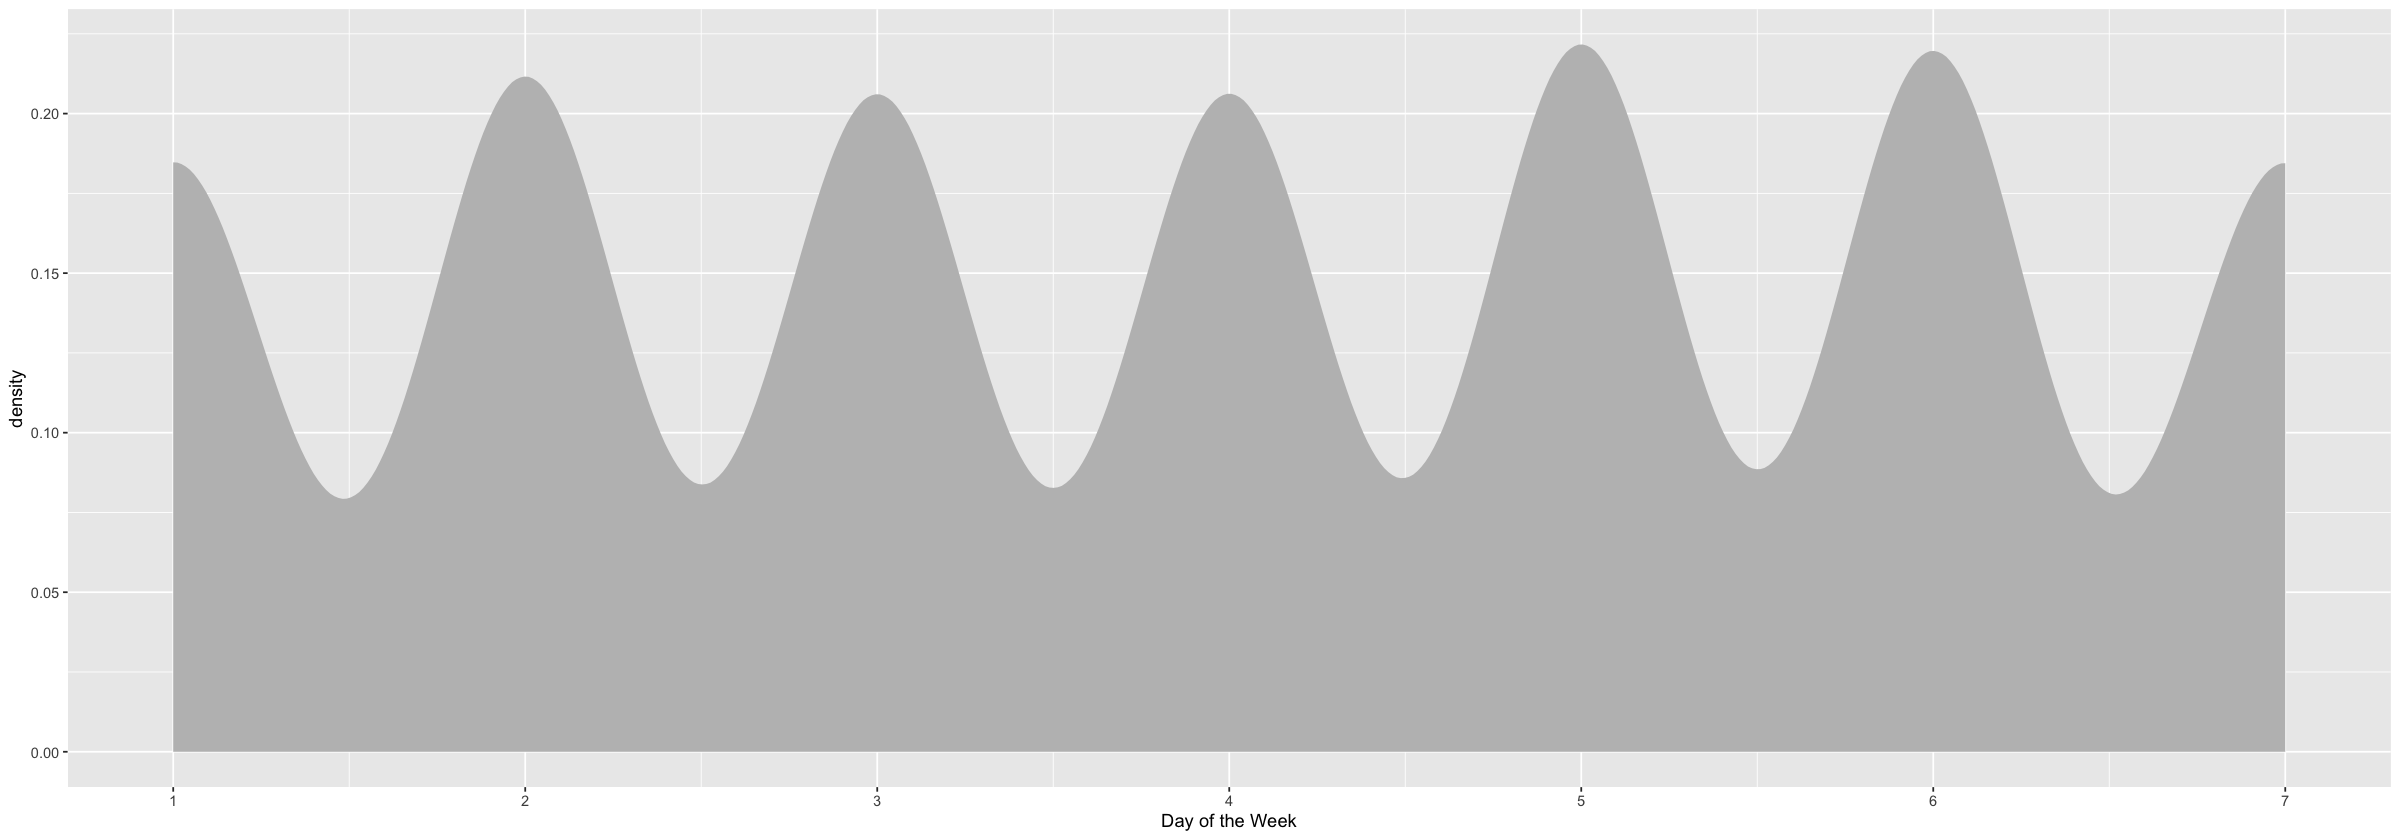

In [35]:
Trips %>%
  ggplot(aes(x = lubridate::wday(sdate))) +
    geom_density(fill = 'gray', color = NA) +
    xlab('Day of the Week') +
    scale_x_continuous(breaks = 0:8)

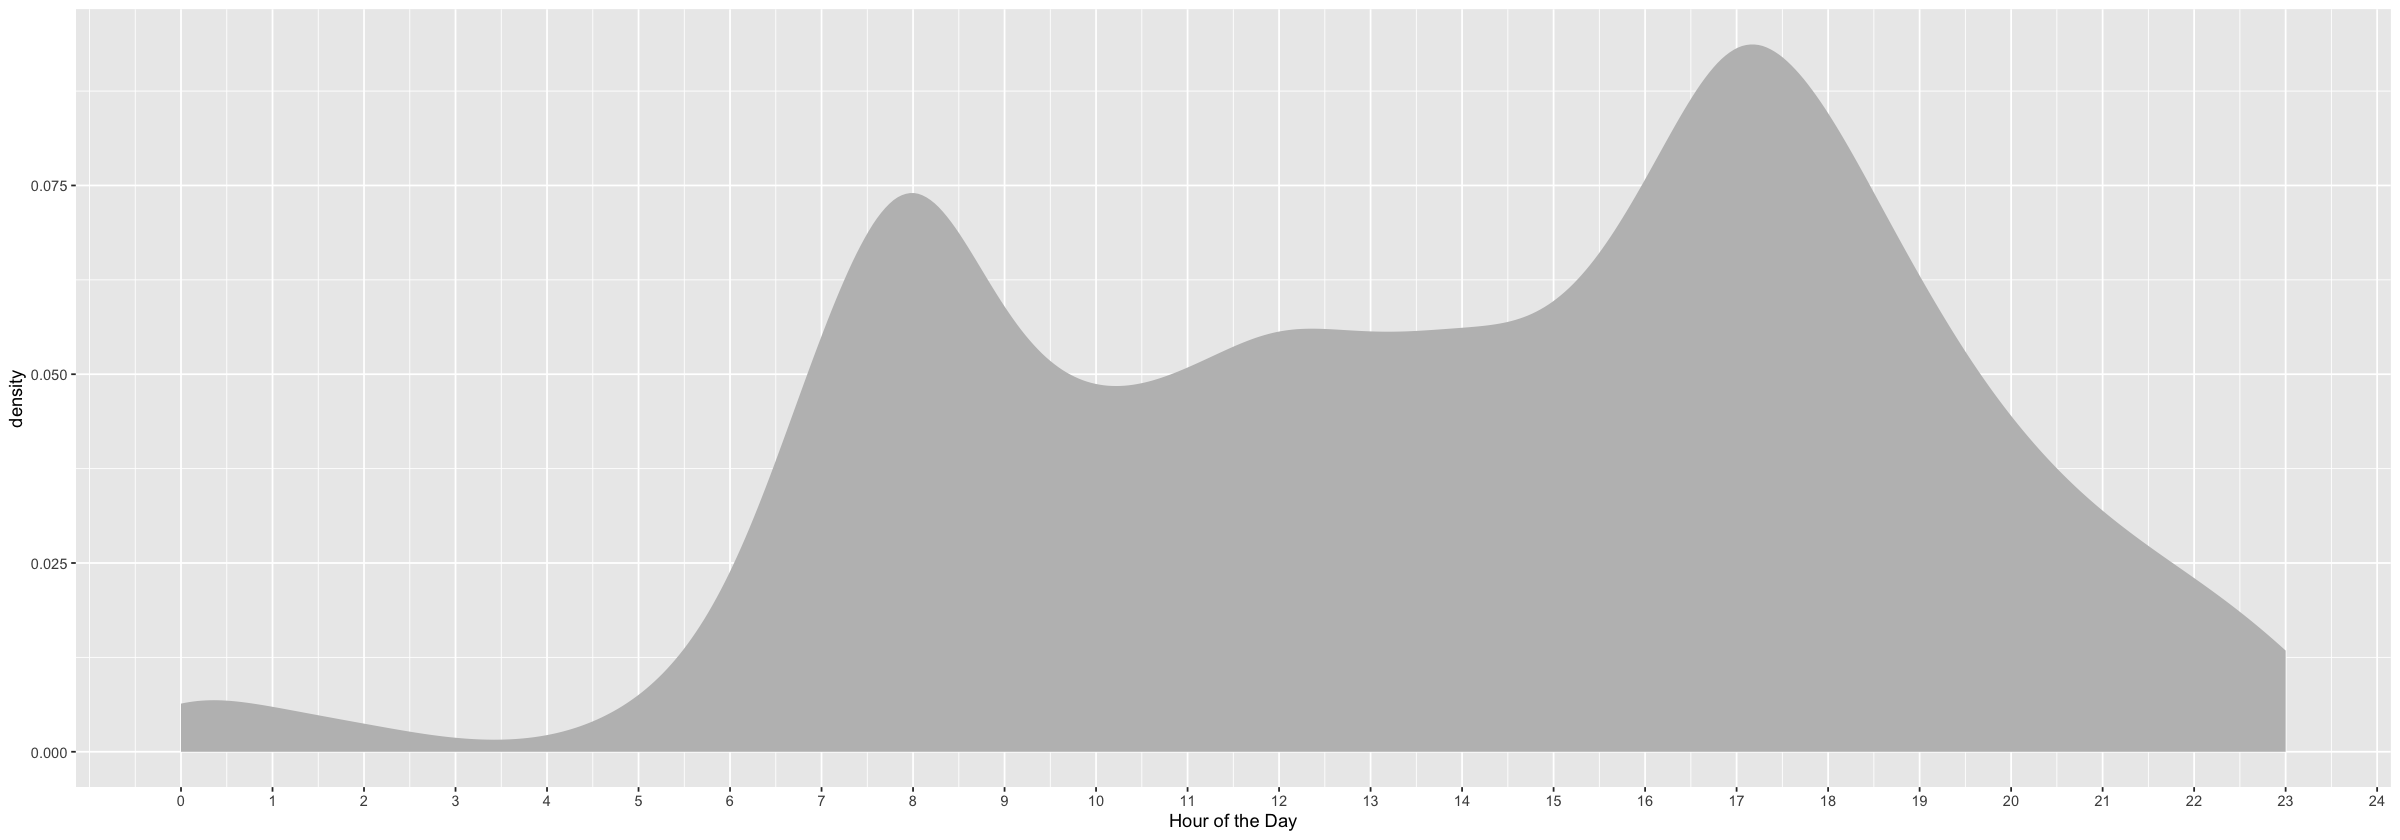

In [36]:
Trips %>%
  ggplot(aes(x = lubridate::hour(sdate))) +
    geom_density(fill = 'gray', color = NA) +
    xlab('Hour of the Day') +
    scale_x_continuous(breaks = 0:24)

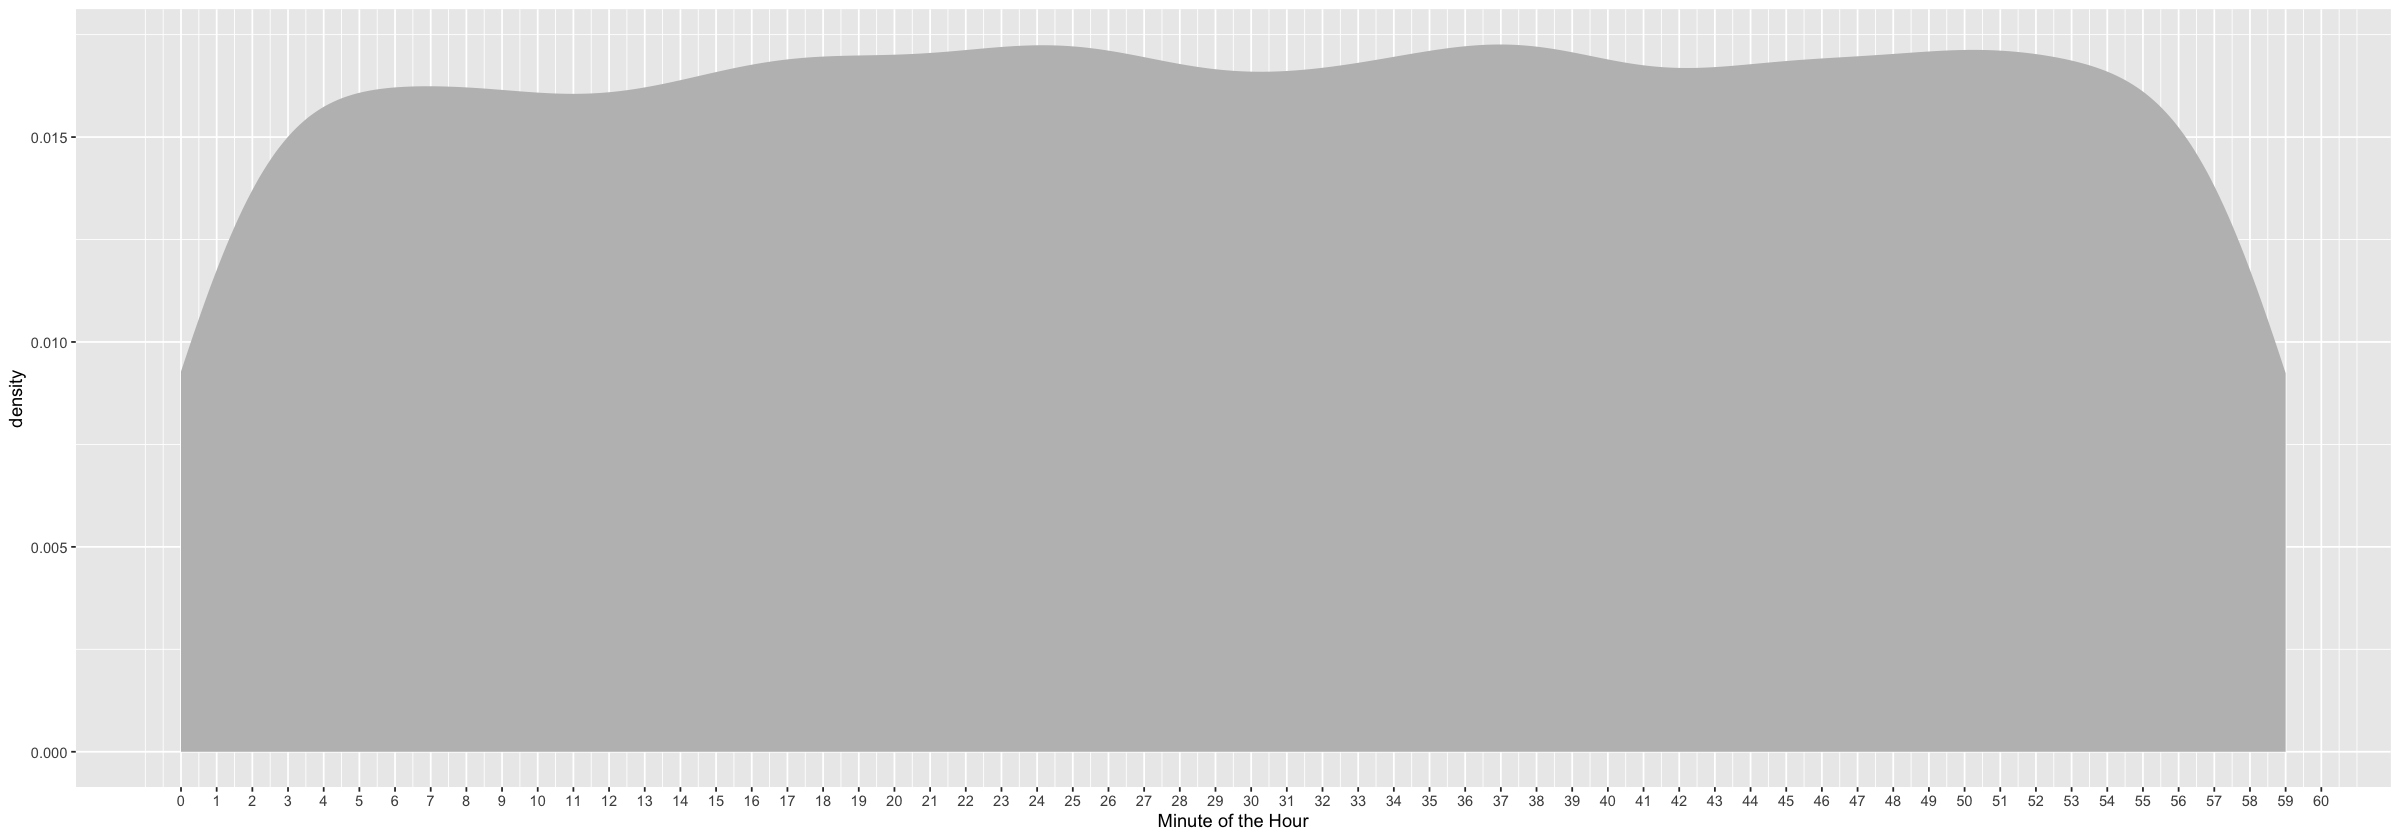

In [37]:
Trips %>%
  ggplot(aes(x = lubridate::minute(sdate))) +
    geom_density(fill = 'gray', color = NA) +
    xlab('Minute of the Hour') +
    scale_x_continuous(breaks = 0:60)

In [38]:
Trips %>%
  mutate(
    HOD = lubridate::hour(sdate),
    DOW = lubridate::wday(sdate),
  ) %>%
  group_by(HOD, DOW, client) %>%
  summarize(total = n()) %>%
  head()

`summarise()` has grouped output by 'HOD', 'DOW'. You can override using the
`.groups` argument.


HOD,DOW,client,total
<int>,<dbl>,<chr>,<int>
0,1,Casual,1
0,1,Registered,30
0,2,Registered,5
0,3,Casual,2
0,3,Registered,8
0,4,Registered,7


`summarise()` has grouped output by 'HOD', 'DOW'. You can override using the
`.groups` argument.


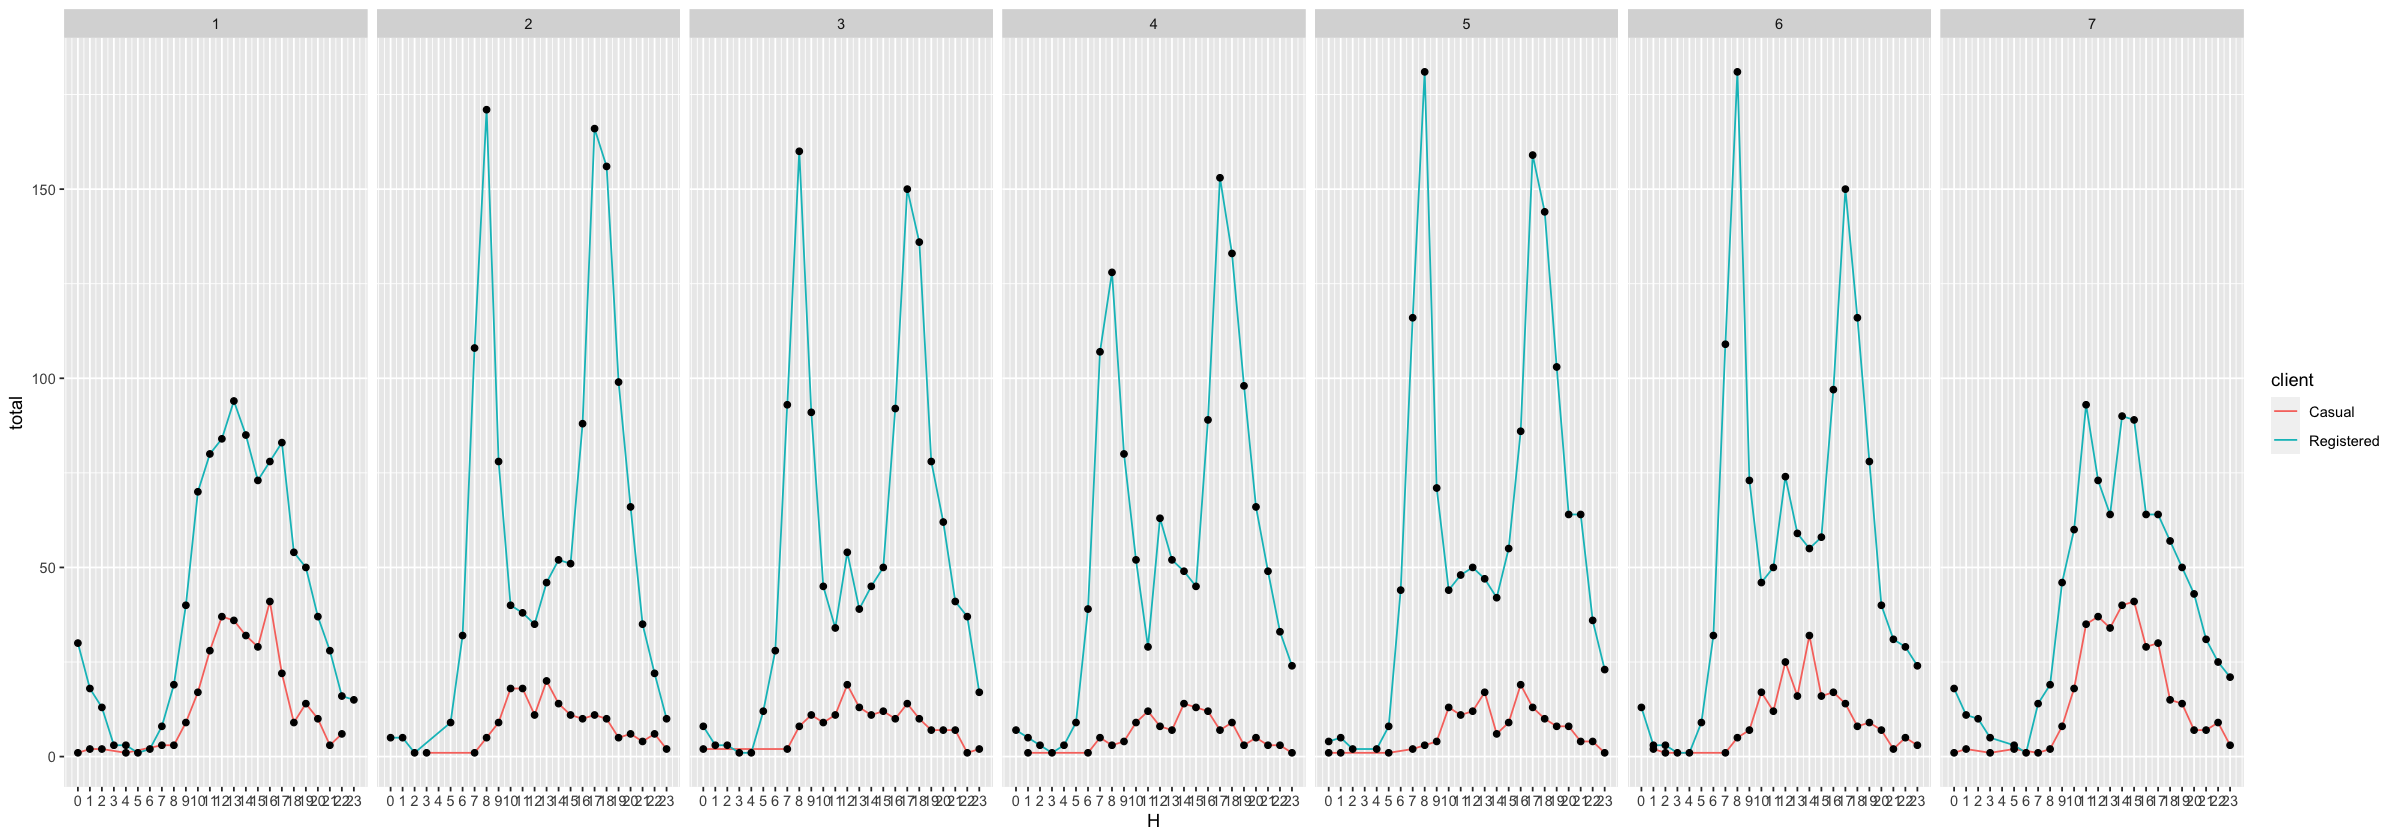

In [39]:
options(repr.plot.width=20)

Trips %>%
  mutate(
    HOD = lubridate::hour(sdate),
    DOW = lubridate::wday(sdate),
  ) %>%
  group_by(HOD, DOW, client) %>%
  summarize(total = n()) %>%
  ggplot(mapping = aes(x = HOD, y = total)) +
    geom_line(mapping = aes(color = client)) + # the `group` aesthetic is unnecessary when using the `color` aesthetic
    geom_point() +
    facet_wrap(. ~ DOW, nrow = 1) +
    xlab('H') +
    scale_x_continuous(breaks = 0:23)

## How far?

Find the distance between each pair of stations. You know the position from the `lat` and `long` variables in `Stations`. This is enough information to find the distance. The calculation has been implemented in the `haversine()` function. `haversine()` is a transformation function. To use it, create a data table where a case is a pair of stations and there are variables for the latitude and longitude of the starting station and the ending station. To do this, join the `Station` data to itself. The statements `Simple` and `Simple2` show how to create appropriately named variables for joining. Look the `head()` of `Simple` and `Simple2` and make sure you understand how they are related to `Stations`. The joining of `Simple` and `Simple2` should match every station to every other station. (Since a ride can start and end at the same station, it also makes sense to match each station to itself.) This sort of matching does not make use of any matching variables; everything is matched to everything else. This is called a full outer join. (A full outer join matches every case in the left table to each and every case in the right table.) Make sure you understand what the full outer join does before proceeding. For instance, you should be able to predict how many cases the output will have when the left input has n cases and the right has m cases.

[1] There are 347 cases in the `Stations` data table. How many cases will there be in a full outer join of `Simple` to `Simple2`?

$120409 = 347 \times 347$

It's often impractical to carry out a full outer join. For example, joining `BabyNames` to itself with a full outer join will generate a result with more than three trillion cases. (Three trillion cases from the `BabyNames` data is the equivalent of about 5 million hours of MP3 compressed music. A typical human lifespan is about 0.6 million hours.) Perform the full outer join and then use `haversine()` to compute the distance between each pair of stations. Check your result for sensibility. Make a histogram of the station-to-station distances and explain where it looks like what you would expect. (Hint: you could use the Internet to look up the distance from one end of Washington, D.C. to the other.) Once you have `PairDistances`, you can join it with `Trips` to calculate the start-to-end distance of each trip. (Of course, a rider may not go directly from one station to another.)

[2] Look at the variables in `Stations` and `Trips` and explain why `Simple` and `Simple2` were given different variable names for the station.

An `inner_join()` is appropriate for finding the distance of each ride. (Watch out! The `Trips` data and the `PairDistances` data are large enough that the join is expensive: it takes about a minute.) Display the distribution of the ride distances of the ride.

[3] Compare it to the distances between pairs of stations. Are they similar? Why or why not?

In [40]:
Simple <-
  Stations %>%
    select(name, lat, long) %>%
    rename(sstation = name)
Simple2 <-
  Simple %>%
    rename(estation = sstation, lat2 = lat, long2 = long)
StationPairs <-
  merge(Simple, Simple2, by = NULL)
PairDistances <-
  StationPairs %>%
    mutate(distance = haversine(lat, long, lat2, long2)) %>%
    select(sstation, estation, distance)

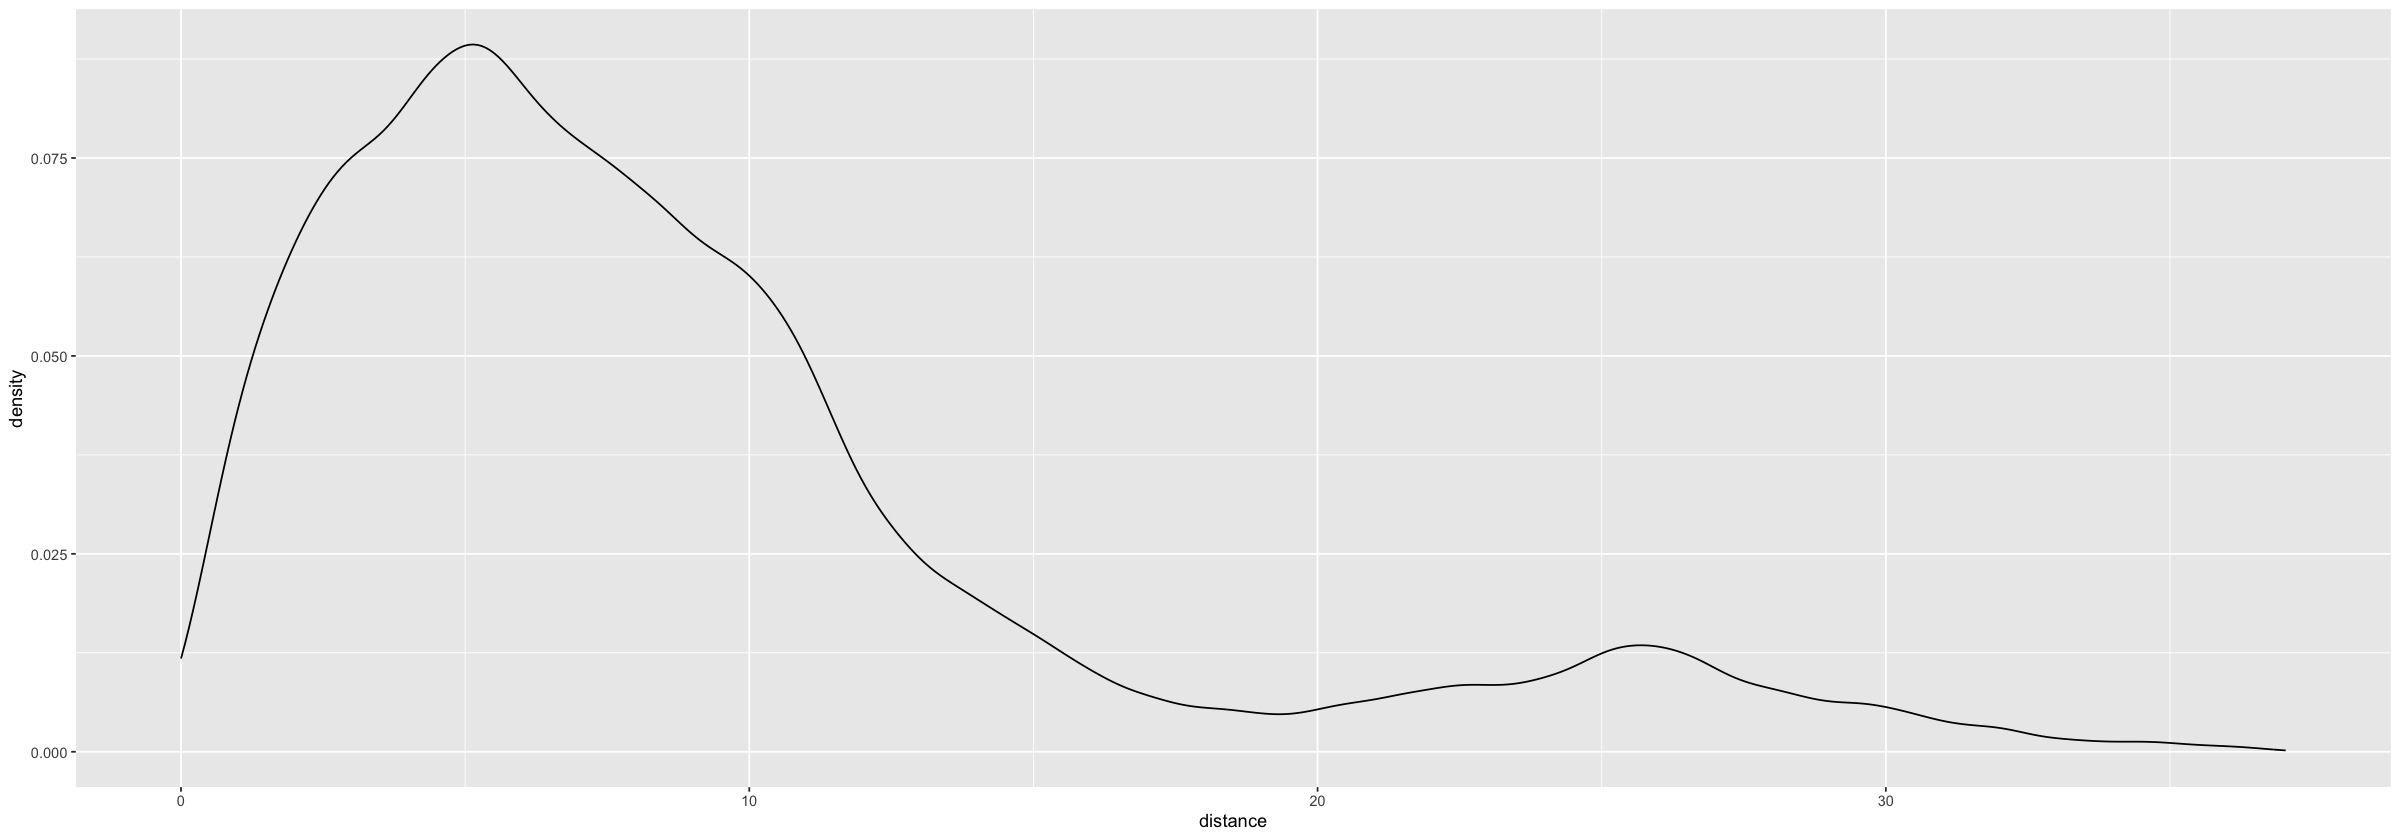

In [41]:
PairDistances %>%
  ggplot() +
    geom_density(aes(x = distance))

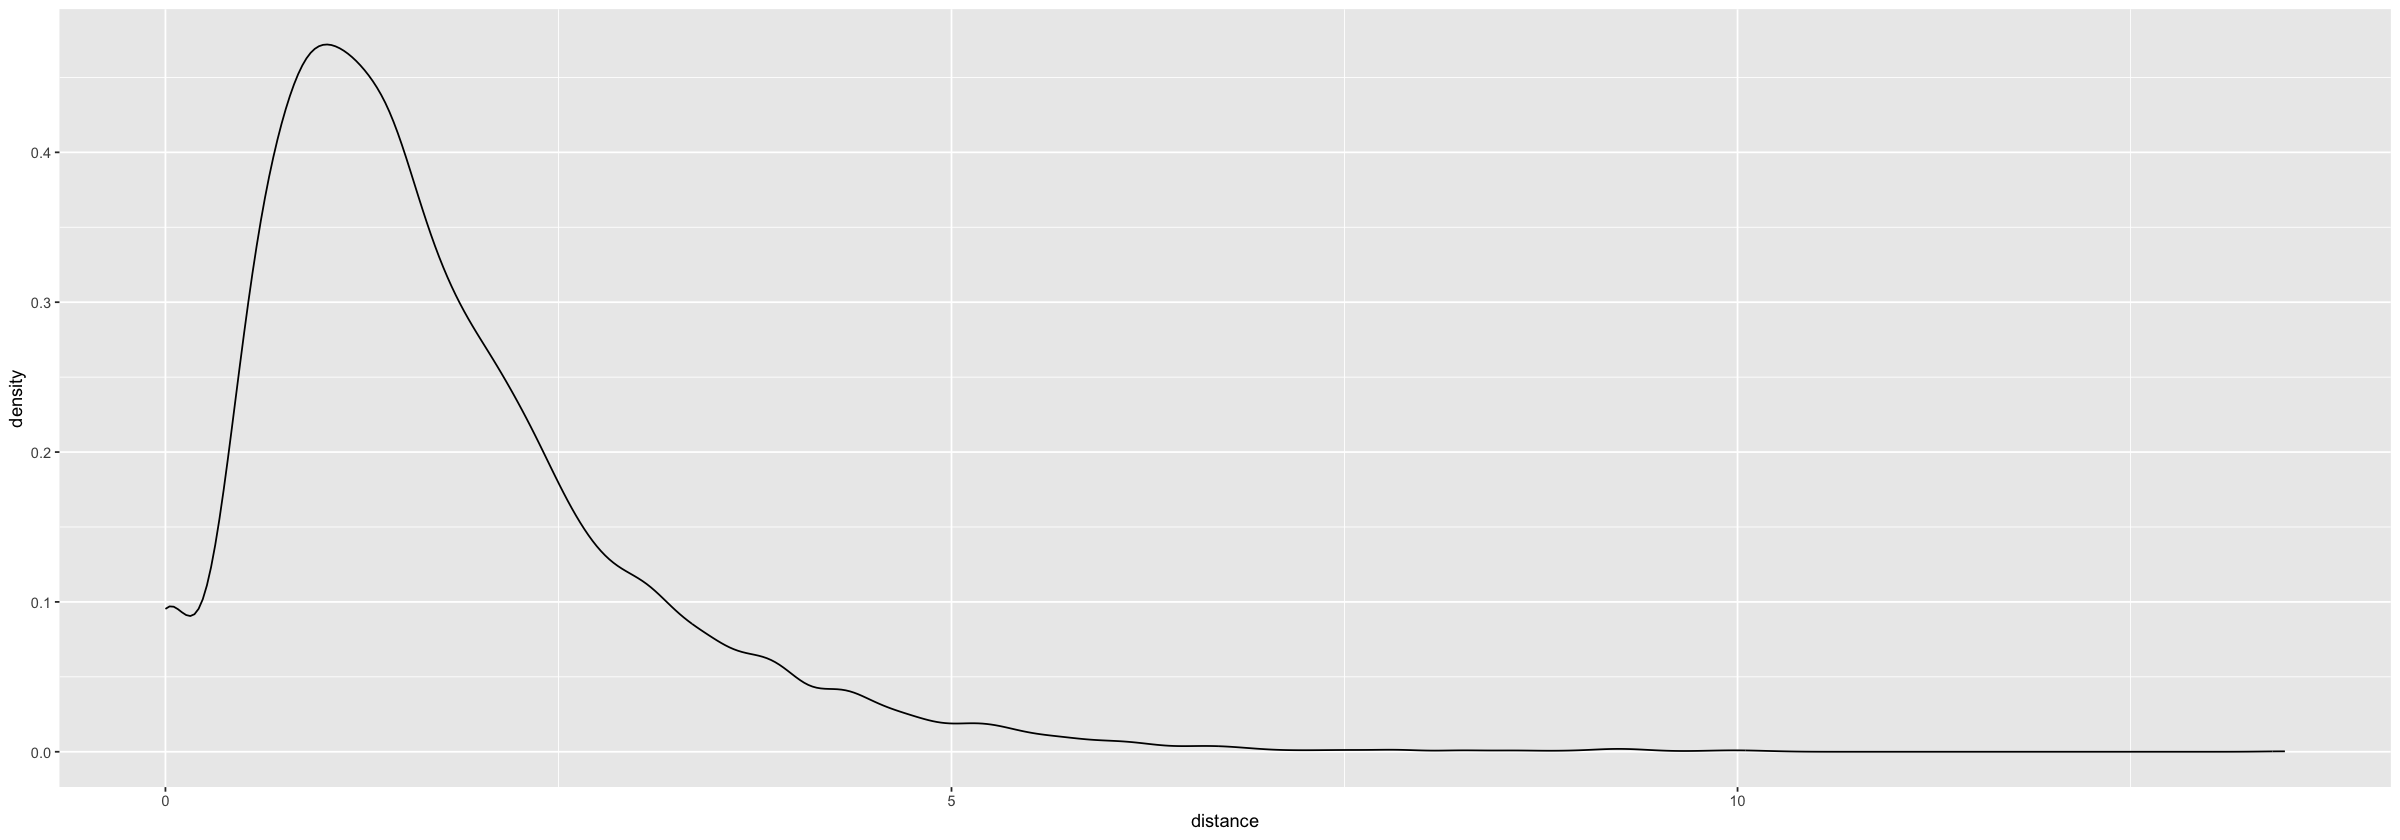

In [42]:
Trips %>%
  inner_join(PairDistances, by = c('sstation', 'estation')) %>%
  ggplot(aes(x = distance)) +
    geom_density()

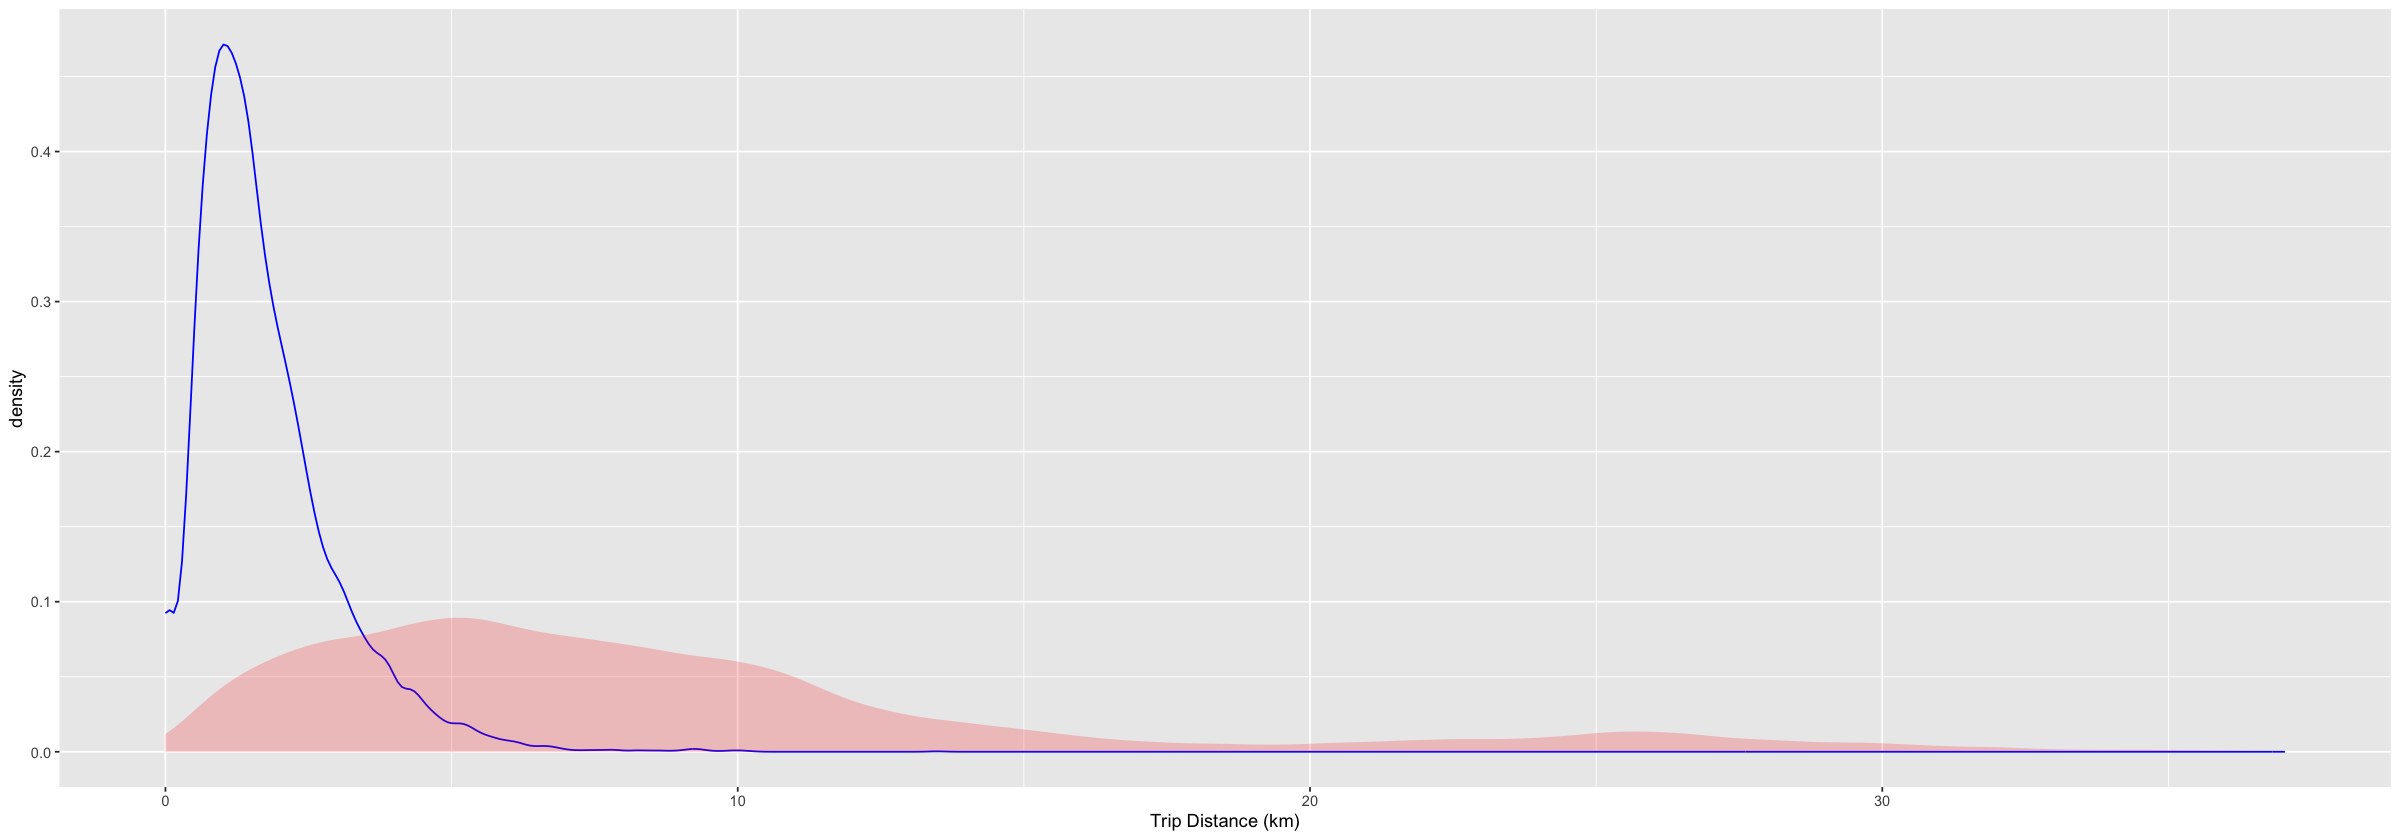

In [43]:
Trips %>%
  inner_join(PairDistances, by = c('sstation', 'estation')) %>%
  ggplot(aes(x = distance)) +
    geom_density(
      color = 'blue'
    ) +
    geom_density(
      alpha = 0.2,
      color = NA,
      data  = PairDistances,
      fill  = 'red'
    ) +
    xlab('Trip Distance (km)')

## Mapping the stations

You can draw detailed maps with the `leaflet` package. You may need to install it. `leaflet` works much like `ggplot()` but provides special facilities for maps.

In [44]:
stationMap <-
  leaflet(Stations) %>%
    addTiles() %>%
    addCircleMarkers(radius = 2, color = 'red')
    #setView(-77.04, 38.9, zoom = 12)
stationMap

Assuming "long" and "lat" are longitude and latitude, respectively



HTML widgets cannot be represented in plain text (need html)

## Long-distance stations

Around each station on the map, draw a circle whose radius reflects the median distance covered by rentals starting at that station. To draw the circles, use the same `leaflet` commands as before, but add in a line like this: `addCircles(radius = ~ mid, color = "blue", opacity = 0.0001)`. For `addCircles()` to draw circles at the right scale, the units of the median distance should be presented in meters rather than kilometers. This will create too much overlap, unfortunately. So, set the radius to be half or one-third the median distance in meters. From your map, explain the pattern you see in the relationship between station location and median distance.